In [3]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from PyEMD import EMD,CEEMDAN, EEMD
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

from ta.trend import ema_indicator

from modules.Utils.utils import loadFromDB, strategyTester,computeStochasticLinearRegression
import pandas as pd


In [4]:
def emd(signal):
    emd = EMD(DTYPE=np.float16, spline_kind='cubic')#CEEMDAN() 
    imfs = emd(signal.values)
    
    t = [i for i in range(len(signal))]
    N = imfs.shape[0]
    fig, axs = plt.subplots(N + 1, 1, figsize=(25,11))
    axs[0].plot(t, signal)
    axs[0].set_title('Original Signal')
    for n, imf in enumerate(imfs):
        axs[n+1].plot(t, imf)
        axs[n+1].set_title(f'IMF {n}')
    
    return imfs

In [5]:
SYMBOL= 'BTC'
df = loadFromDB(f'./data/1h/{SYMBOL}-USDT.csv')
#df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
print(df.shape)
df.head()

(23452, 6)


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-01-01 01:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,1577836800
2020-01-01 02:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,1577840400
2020-01-01 03:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,1577844000
2020-01-01 04:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,1577847600
2020-01-01 05:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,1577851200


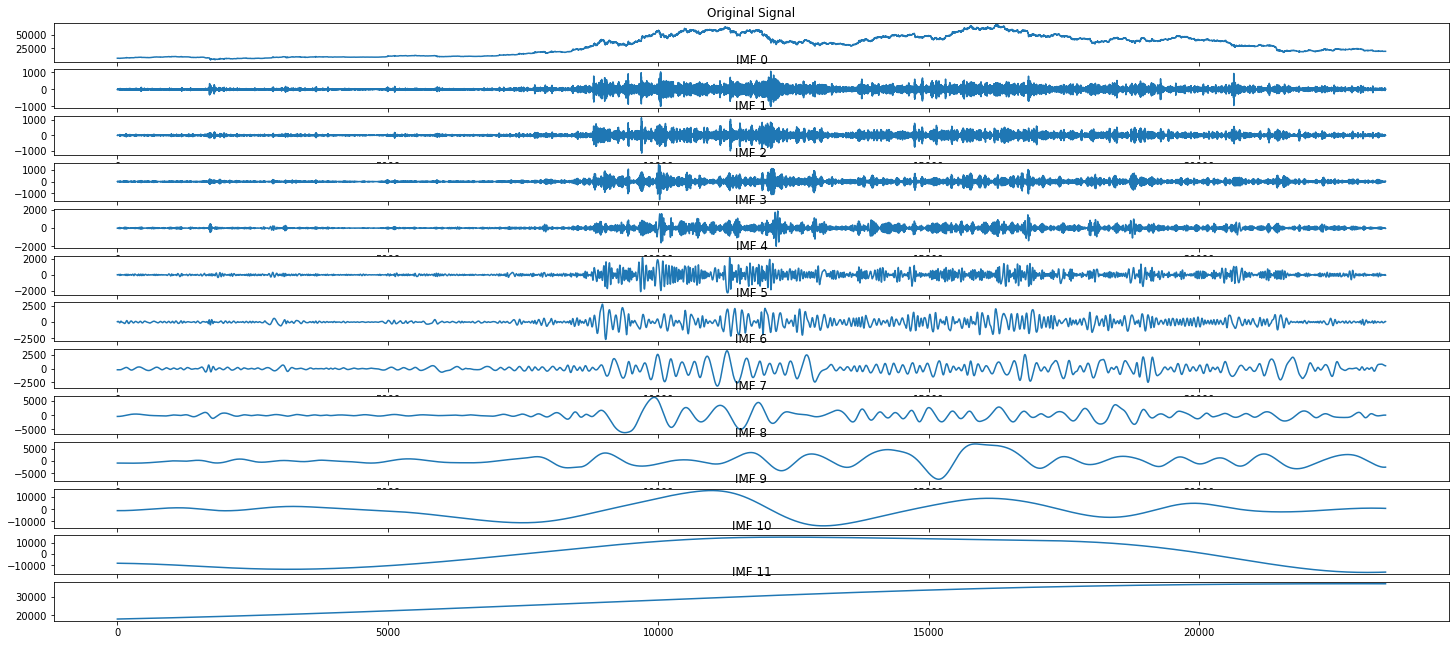

In [6]:
imfs = emd(df["Close"])

In [7]:
def phase_spectrum(imfs):
    imfs_p = []
    fig, axs = plt.subplots(len(imfs), 1, figsize=(25,11))
    for i, imf in enumerate(imfs):
        trans = fft(imf)
        imf_p = np.arctan(trans.imag / trans.real)
        
        imfs_p.append(imf_p)
        
        axs[i].plot(imf_p, 'o')
        axs[i].set_title(f'IMF {i}')
        
    return imfs_p

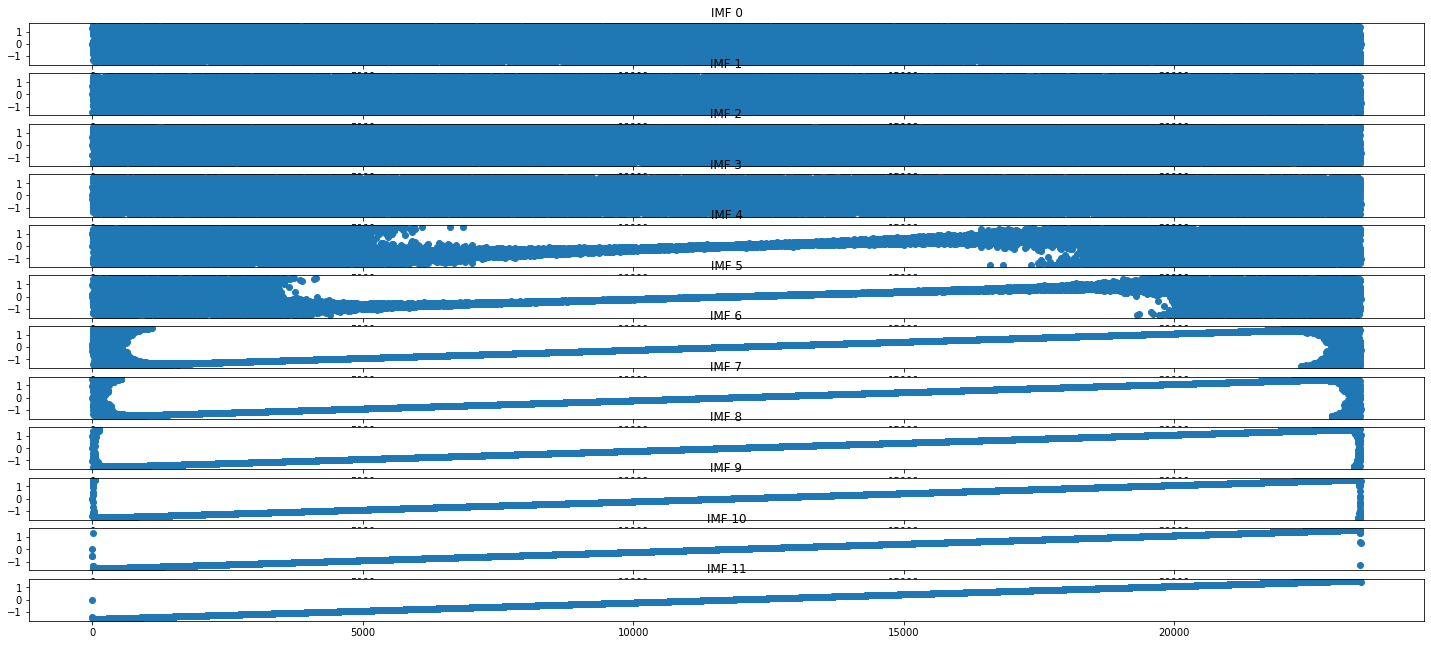

In [8]:
imfs_p = phase_spectrum(imfs)

In [9]:
def phase_mi(phases):
    mis = []
    for i in range(len(phases)-1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0])
        
    return np.array(mis)
mis = phase_mi(imfs_p)

In [10]:
def divide_signal(signal, imfs, mis, cutoff=0.75):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:cut_point], axis=0)
    deterministic_component = np.sum(imfs[cut_point:], axis=0)
    
    t = [i for i in range(len(signal))]
    
    fig, axs = plt.subplots(3, 1, figsize=(25,11))
    axs[0].plot(t, signal.values)
    axs[0].set_title('Original Signal')
    
    axs[1].plot(t, stochastic_component)
    axs[1].set_title('Stochastic Component')
    
    axs[2].plot(t, deterministic_component)
    axs[2].set_title('Deterministic Component')
    
    return stochastic_component, deterministic_component

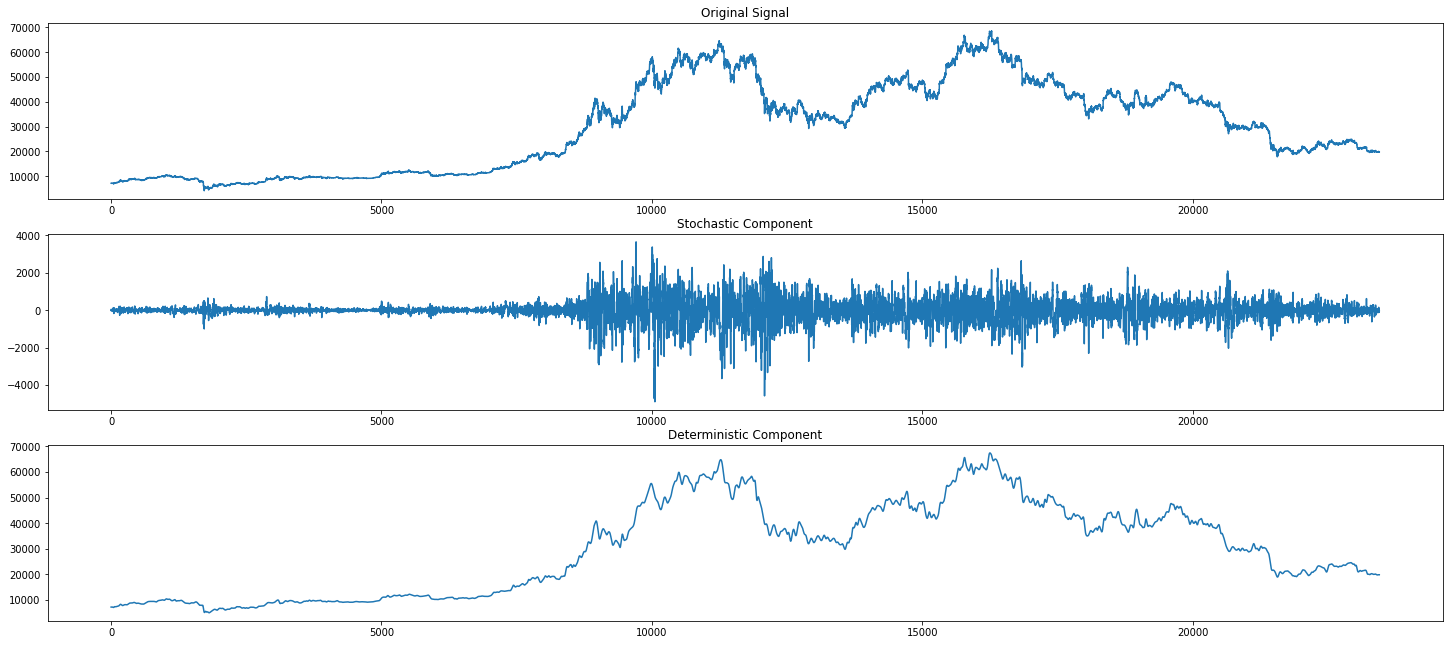

In [11]:
stochastic_component, deterministic_component = divide_signal(df["Close"], imfs, mis,cutoff=0.96)

In [12]:
df['deterministic_component'] = deterministic_component
df['stochastic_component'] = stochastic_component
df['deterministic_component_diff'] = df['deterministic_component'].diff()
df.dropna(inplace=True)

Period : [2020-01-01 02:00:00] -> [2022-09-05 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 86095705.35 $
Performance vs US Dollar : 8609470.53 %
Buy and Hold Performence : 174.11 %
Performance vs Buy and Hold : 4944661.97 %
Best trade : +32.58 %, the 2021-02-11 02:00:00
Worst trade : -6.45 %, the 2022-06-15 18:00:00
Worst drawBack : -7.000000000000001 %
Total fees :  3778498.58 $

----- Trades Informations -----
Total trades on period : 249
Number of positive trades : 218
Number of negative trades :  31
Trades win rate ratio : 87.55 %
Average trades performance : 4.88 %
Average positive trades : 5.71 %
Average negative trades : -0.9 %

----- Plot -----


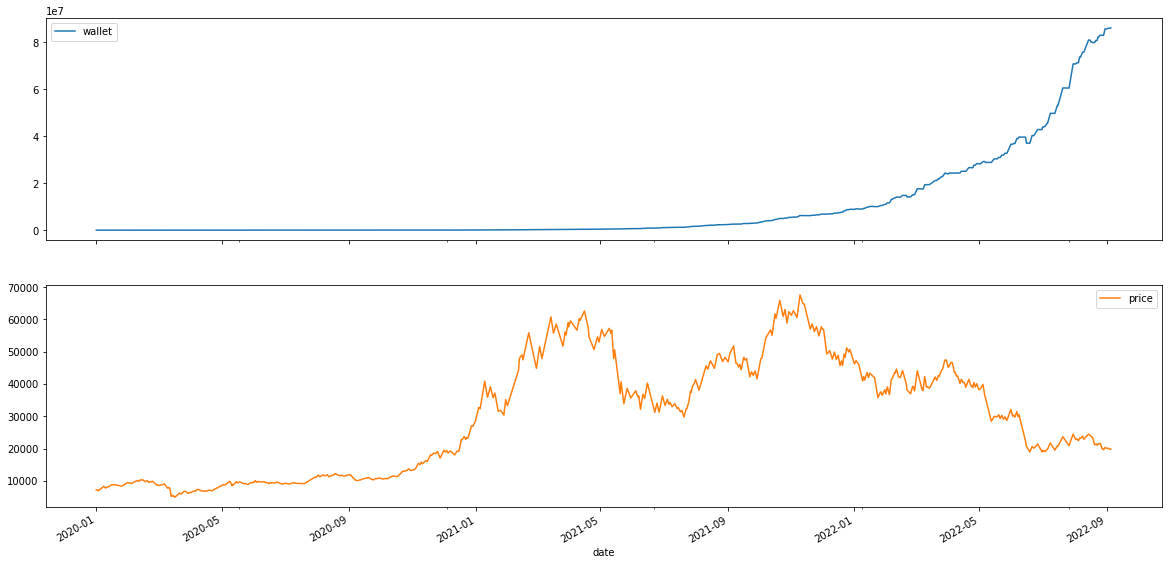

In [13]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.deterministic_component_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.deterministic_component_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

In [14]:
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

In [15]:

import matplotlib.pyplot as plt

p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(df))), df.Close.values, legend_label="Close", line_width=2, )
p.line(list(range(len(df))), df.deterministic_component.values, legend_label="Deterministic", line_width=2, color='orange')

p.legend.location = "top_left"

q = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value',width=1500, height=600,)
# Add the HoverTool to the figure
q.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00}"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
q.line(list(range(len(df))), df.deterministic_component_diff.values, legend_label="Deterministic", line_width=2, color='orange')
q.legend.location = "top_left"

show(column(p, q))

# With predictions

In [16]:
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures
df = generateDatesFeatures(df)
#df = computeLaggingLinearRegression(df,"Close",20,filter_ceof=False,derivative=False)
df = computeStochasticLinearRegression(df, 'Close',)

from datetime import datetime
import numpy as np

from ta.trend import ema_indicator
df['EMA20'] = ema_indicator(df['Close'],20)

df.dropna(inplace=True)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp',
       'deterministic_component', 'stochastic_component',
       'deterministic_component_diff', 'Month', 'Year', 'Week', 'Hour',
       'Year_sin', 'Year_cos', 'prediction', 'EMA20'],
      dtype='object')

## Correlation

<AxesSubplot:>

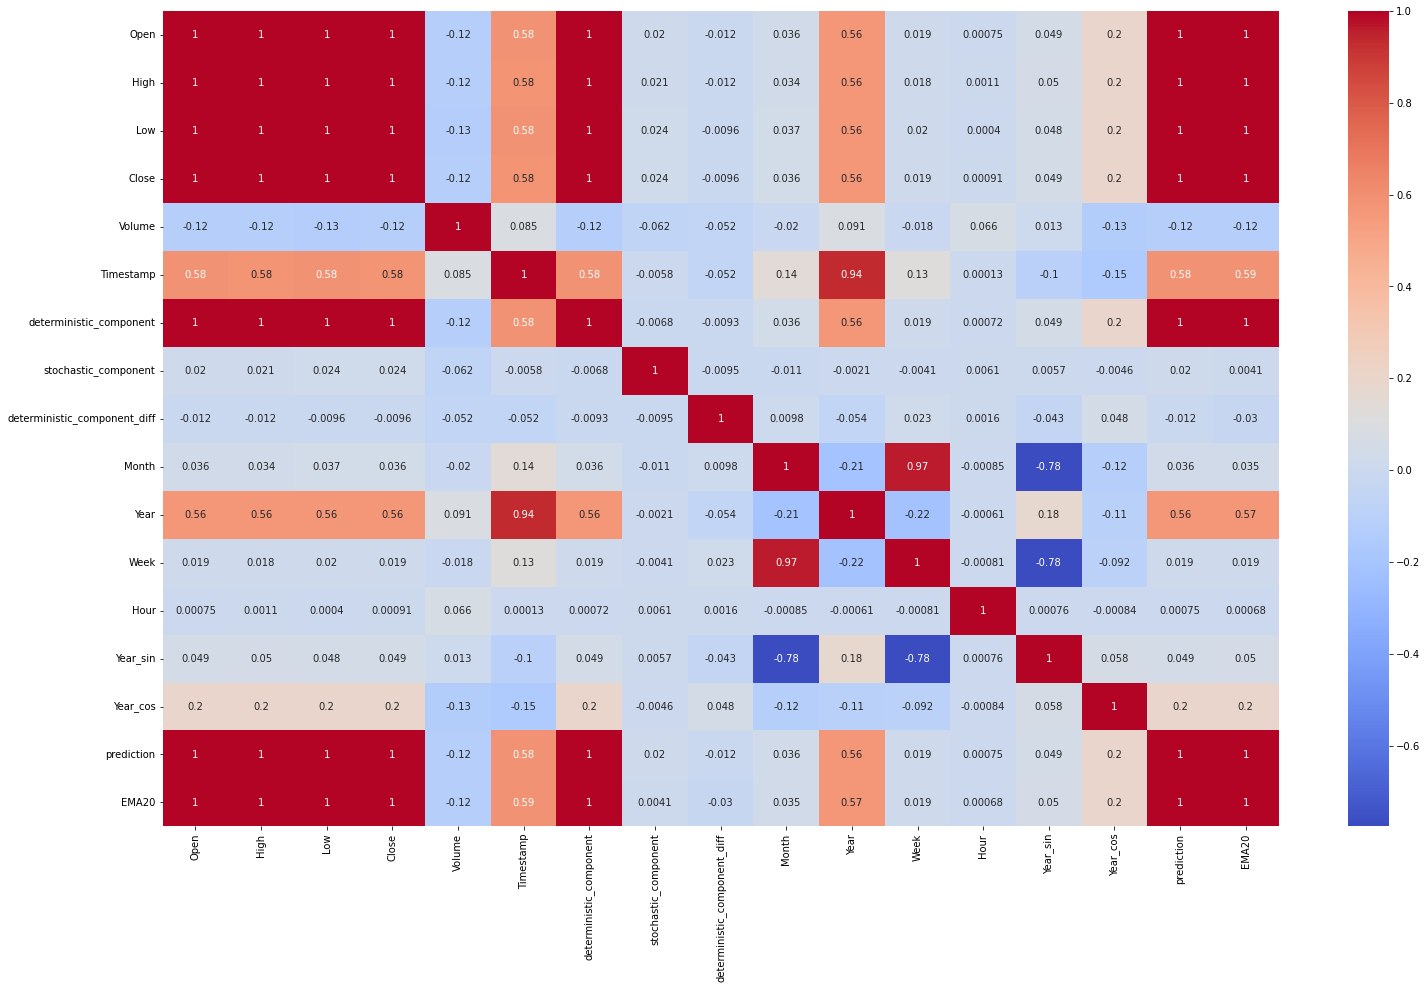

In [17]:
# plot the heatmap
fig, ax = plt.subplots(1, figsize=(25,15))
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap='coolwarm',
        xticklabels=df.columns,
        yticklabels=df.columns,ax=ax)

## Models

### Double head model

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

label = 'Close'

features = [ 'Close', 'deterministic_component']

#scaler_features = MinMaxScaler()
#scaled_features = scaler_features.fit_transform(df[features])

scaler_features_1 = MinMaxScaler()
scaled_features_1 = scaler_features_1.fit_transform(df[['Close','prediction']])

#joblib.dump(scaler_features_1, f"./models/scaler_features_1_Close_prediction.save")

scaler_features_2 = MinMaxScaler()
scaled_features_2 = scaler_features_2.fit_transform(df[['deterministic_component','EMA20']])

#joblib.dump(scaler_features_2, f"./models/scaler_features_1_deterministic_EMA20.save")

scaler_labels = MinMaxScaler()
scaled_labels = scaler_labels.fit_transform(df[[label]])

#joblib.dump(scaler_features_2, f"./models/scaler_labels_1_Close.save")

#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2, f_regression
#
#select = SelectKBest(score_func=f_regression, k=6)
#z = select.fit_transform(scaled_features,scaled_labels)
#scaled_features=z
            
days_in_future=20#10
lag = 50#30


X_1 = np.array([scaled_features_1[i-lag:i,:] for i in range(lag, len(scaled_features_1)-days_in_future)])
X_2 = np.array([scaled_features_2[i-lag:i,:] for i in range(lag, len(scaled_features_2)-days_in_future)])
y = np.array([scaled_labels[i:i+days_in_future].reshape(1,-1)[0] for i in range(lag, len(scaled_labels)-days_in_future)])
    
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [53]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten,MaxPooling1D, Conv1D, Dropout, LSTM, Bidirectional, GRU, TimeDistributed, RepeatVector, Input, concatenate, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate

early_stop = EarlyStopping(
    monitor='val_loss', min_delta=1e-5, patience=6, verbose=1, mode='min',
    baseline=None, restore_best_weights=True)


visible1 = Input(shape=(lag, 2))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='elu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)
# second input model
visible2 = Input(shape=(lag, 2))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='elu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)
# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(20, activation='relu')(merge)
output = TimeDistributed(Dense(days_in_future,activation='linear'))(dense)
#output = Dense(days_in_future,activation='linear')(dense)

model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')

model.fit([X_1, X_2],
          y,
          epochs=100,
          batch_size=32,
          verbose=1,
          validation_split=0.2,
          callbacks=[early_stop],
          use_multiprocessing=True,shuffle=True)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_54904\4293166928.py", line 29, in <cell line: 29>
      model.fit([X_1, X_2],
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [32,24,20] vs. [32,20]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_75085]

In [20]:
pred = model.predict([X_1, X_2])

731/731 [==============================] - 1s 1ms/step


In [26]:
from random import randint

ind = randint(0,len(pred)-1)
print(ind)

p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(pred[ind]))), pred[ind], legend_label="Prediction", line_width=2, color='orange')
p.line(list(range(len(pred[ind]))), y[ind], legend_label="Deterministic", line_width=2, )

p.legend.location = "top_left"

show(p)

21156


In [76]:
#model.save('./models/conv1d_double_head_1h_50_20.h5')

### Attention Seq2Seq model

In [54]:

features = [ 'Close', 'deterministic_component']

scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df[['Close','prediction']])

#joblib.dump(scaler_features_1, f"./models/scaler_features_1_Close_prediction.save")


scaler_labels = MinMaxScaler()
scaled_labels = scaler_labels.fit_transform(df[['Close','prediction']])

#joblib.dump(scaler_features_2, f"./models/scaler_labels_1_Close.save")

#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2, f_regression
#
#select = SelectKBest(score_func=f_regression, k=6)
#z = select.fit_transform(scaled_features,scaled_labels)
#scaled_features=z
            
days_in_future=20#10
lag = 100#30


X = np.array([scaled_features[i-lag:i,:] for i in range(lag, len(scaled_features)-days_in_future)])
y = np.array([scaled_labels[i:i+days_in_future] for i in range(lag, len(scaled_labels)-days_in_future)])
#y = np.array([scaled_labels[i:i+days_in_future].reshape(1,-1)[0] for i in range(lag, len(scaled_labels)-days_in_future)])
X.shape, y.shape

((23309, 100, 2), (23309, 20, 2))

In [56]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten,MaxPooling1D, Conv1D, BatchNormalization, Activation, dot, LSTM, TimeDistributed, RepeatVector, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam

luong = False

early_stop = EarlyStopping(
    monitor='val_loss', patience=50, verbose=1, mode='min',
    baseline=None, restore_best_weights=True)

n_hidden = 100

input_train = Input(shape=(X.shape[1], X.shape[2]))
output_train = Input(shape=(X.shape[1], X.shape[2]))

if luong:
    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
        n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
        return_state=True, return_sequences=True)(input_train)

    encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)


    decoder_input = RepeatVector(days_in_future)(encoder_last_h)

    decoder_stack_h = LSTM(n_hidden,
                        activation='elu',
                        dropout=0.2,
                        recurrent_dropout=0.2,
                        return_state=False, return_sequences=True)(decoder_input,
                                                                    initial_state=[encoder_last_h,
                                                                                    encoder_last_c])
    
    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)

    context = dot([attention, encoder_stack_h], axes=[2,1])
    context = BatchNormalization(momentum=0.6)(context)

    decoder_combined_context = concatenate([context, decoder_stack_h])
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
else:
    
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
    encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder = RepeatVector(days_in_future)(encoder_last_h1)
    decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
        decoder, initial_state=[encoder_last_h1, encoder_last_c])
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

model.fit(X,
          y,
          epochs=100,
          batch_size=128,
          verbose=1,
          validation_split=0.2,
          callbacks=[early_stop],
          use_multiprocessing=True,shuffle=True)


Epoch 1/100
146/146 [==============================] - 51s 323ms/step - loss: 0.3055 - mae: 0.1217 - val_loss: 8.9419e-04 - val_mae: 0.0260
Epoch 2/100
146/146 [==============================] - 46s 315ms/step - loss: 0.0025 - mae: 0.0386 - val_loss: 3.0343e-04 - val_mae: 0.0137
Epoch 3/100
146/146 [==============================] - 47s 320ms/step - loss: 0.0023 - mae: 0.0371 - val_loss: 3.1998e-04 - val_mae: 0.0134
Epoch 4/100
146/146 [==============================] - 46s 318ms/step - loss: 0.0022 - mae: 0.0359 - val_loss: 0.0017 - val_mae: 0.0351
Epoch 5/100
146/146 [==============================] - 47s 321ms/step - loss: 0.0024 - mae: 0.0385 - val_loss: 4.5515e-04 - val_mae: 0.0175
Epoch 6/100
146/146 [==============================] - 48s 326ms/step - loss: 0.0020 - mae: 0.0340 - val_loss: 0.0018 - val_mae: 0.0400
Epoch 7/100
146/146 [==============================] - 47s 325ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0059 - val_mae: 0.0687
Epoch 8/100
146/146 [===========

In [30]:
pred = model.predict(X)

729/729 [==============================] - 25s 33ms/step


In [46]:
from random import randint


ind = randint(0,len(pred)-1)
print(ind)

p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(pred[ind]))), pred[ind].reshape(2,days_in_future)[1], legend_label="Prediction", line_width=2, color='orange')
p.line(list(range(len(pred[ind]))), y[ind].reshape(2,days_in_future)[1], legend_label="Deterministic", line_width=2, )

p.legend.location = "top_left"

show(p)

4233


## Real conditons test

In [ ]:
def scaleInputData(df,lag):
    scaled_features_1 = joblib.load(f"./models/scaler_features_1_Close_prediction.save").transform(df[['Close','prediction']])
    X_1 = np.array([scaled_features_1[i-lag:i,:] for i in range(lag, len(scaled_features_1))])

    scaled_features_2 = joblib.load(f"./models/scaler_features_1_deterministic_EMA20.save").transform(df[['deterministic_component','EMA20']])
    X_2 = np.array([scaled_features_2[i-lag:i,:] for i in range(lag, len(scaled_features_2))])
    return X_1, X_2



In [14]:
df_final = pd.DataFrame()
for col in df.columns:
    df_final[col]=np.nan


,Open,High,Low,Close,Volume,Timestamp,deterministic_component,stochastic_component,deterministic_component_diff


In [ ]:
from multiprocessing import Pool, cpu_count

kucoin_range = 1500

def processBatch(i):
    df_i = df.iloc[i:i+kucoin_range]
    imfs = emd(df_i["Close"])
    imfs_p = phase_spectrum(imfs)
    mis = phase_mi(imfs_p)
    stochastic_component, deterministic_component = divide_signal(df_i["Close"], imfs, mis,cutoff=0.96)
    df_i['deterministic_component'] = deterministic_component
    df_i['stochastic_component'] = stochastic_component
    df_i['deterministic_component_diff'] = df_i['deterministic_component'].diff()
    return df_i.iloc[-1]
    #df_final = df_final.append(df_i.iloc[-1],ignore_index=True)
    #print(f'{len(df_final)} records')
    
with Pool(cpu_count()) as pool:
    # call the same function with different data in parallel
    for result in pool.map(processBatch, range(len(df)-kucoin_range)):
        # report the value to show progress
        df_final = df_final.append(result,ignore_index=True)
        print(f'{len(df_final)} records')

In [ ]:
from datetime  import datetime
df_final['date'] = df_final['Timestamp'].astype(int).apply(lambda x: datetime.fromtimestamp(x))
df_final.sort_values('date',inplace=True)
df_final.set_index('date',inplace=True)
df_final

In [15]:
strategyTester(df_final,buyCondition,sellCondition,equity=1000)